This notebook downloads a small piece of a text dataset to local cache (`/Users/USER/.cache/huggingface/datasets` on macbook). Then, you should manually install the files (which are dicts for activations and locations for each feature) from [https://huggingface.co/datasets/MrGonao/raw_features_gemma16/tree/main](https://huggingface.co/datasets/MrGonao/raw_features_gemma16/tree/main) to the features folder. After doing this, the code below will find you the activating documents for each feature. 

### Get Contexts and View Batch

In [4]:
import torch
#get context
def get_context(batch: list[str], pos: int, n=5) -> str:
    context = ''.join([s for s in batch[pos-n:pos+n] if s != '\n'])
    return context

def view_batch(n: int, tokens: torch.Tensor, tokenizer) -> list[str]:
    assert(tokens.ndim == 2 and tokens.shape[1] == 256)
    if n >= len(tokens):
        return None
    doc = tokens[n]
    return tokenizer.batch_decode(doc)

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_parse_tree(parse_dict):
    G = nx.DiGraph()
    for token in parse_dict:
        G.add_node(token['text'])
        for child in token['children']:
            G.add_edge(token['text'], child)
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)  # You can also try 'shell_layout', 'circular_layout', etc.
    nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=2000, font_size=12, font_weight="bold")
    plt.show()

In [8]:
from graphs import load_tokens, make_parse_tree
tokens, tokenizer = load_tokens("google/gemma-2-9B", "kh4dien/fineweb-100m-sample")

def visualize_feature(n, activations, locations, k=5):
    """
    Visualize top k activated contexts for a feature.
    Parameters
    ----------
    n : int
        The feature number to visualize.
    activations : array_like
        The activations of all features.
    locations : array_like
        The locations (batch, position, feature) of all activations.
    k : int, optional
        The number of top activated contexts to visualize. Defaults to 5.
    """
    print(f"Visualizing Feature {n}")
    idx = locations[:,2]== n
    locations = locations[idx]
    activations = activations[idx]
    location_dicts = []
    for location, activation in zip(locations, activations):
        d = {}
        d['batch'] = location[0]
        d['position'] = location[1]
        d['feature'] = location[2]
        d['activation'] = activation
        location_dicts.append(d)
    sorted_location_dicts = sorted(location_dicts, key=lambda x: x['activation'], reverse=True)
    count = 0
    #visualize top trees first.
    for d in sorted_location_dicts:
        batch = view_batch(int(d['batch']), tokens, tokenizer)
        if batch != None:
                count += 1
                pos = d['position']
                context = get_context(batch, pos) #todo: figure out better parse tree context e.g. by punct.
                parse_tree = make_parse_tree(context)
                visualize_parse_tree(parse_tree)
                print(f'{batch[pos]:<15} @ {context:<50} {d["activation"]}')
        if count > k:
            break

### Make and Visualize Parse Trees with Spacy

In [9]:
from graphs import load_tokens, load_activations
tokens, tokenizer = load_tokens("google/gemma-2-9B", "kh4dien/fineweb-100m-sample")
activations, locations = load_activations('features/11_0_3275.safetensors')

Visualizing Feature 3000


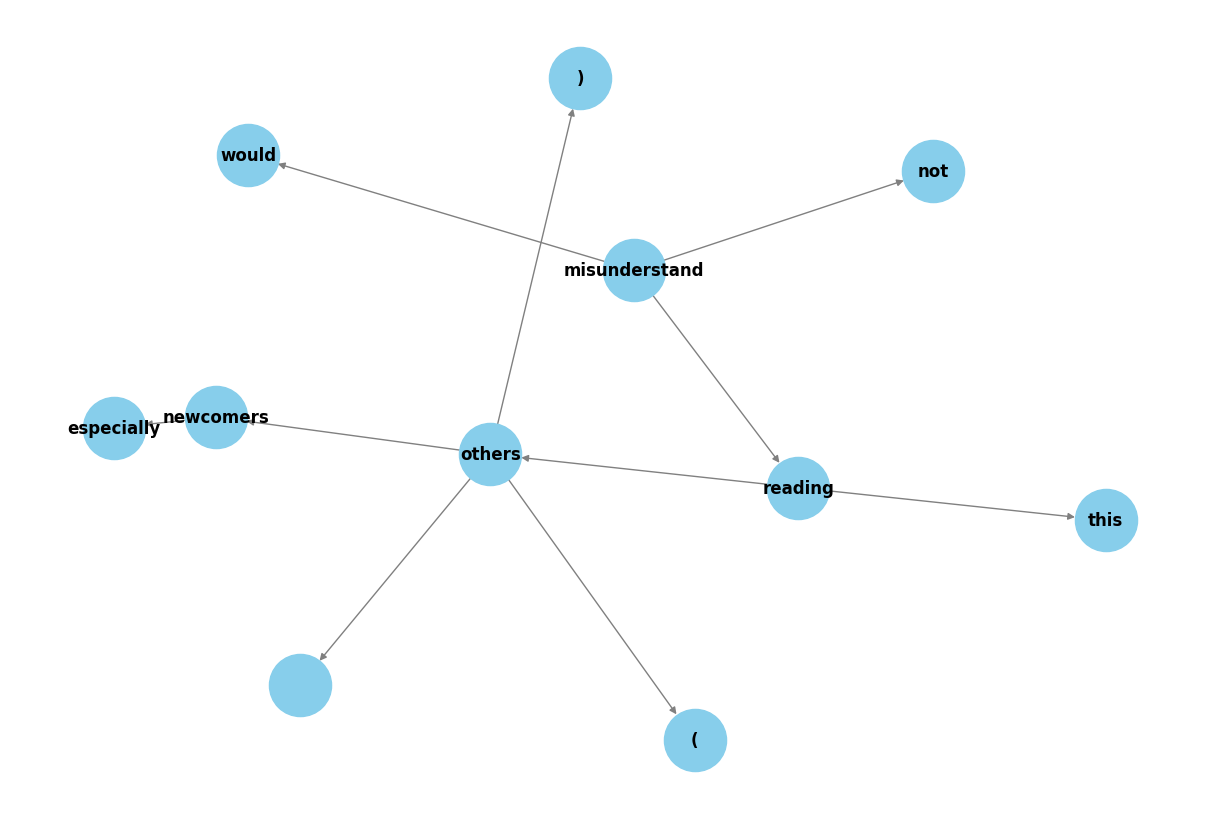

 reading        @  others (especially newcomers) reading this would not misunderstand 44.21875


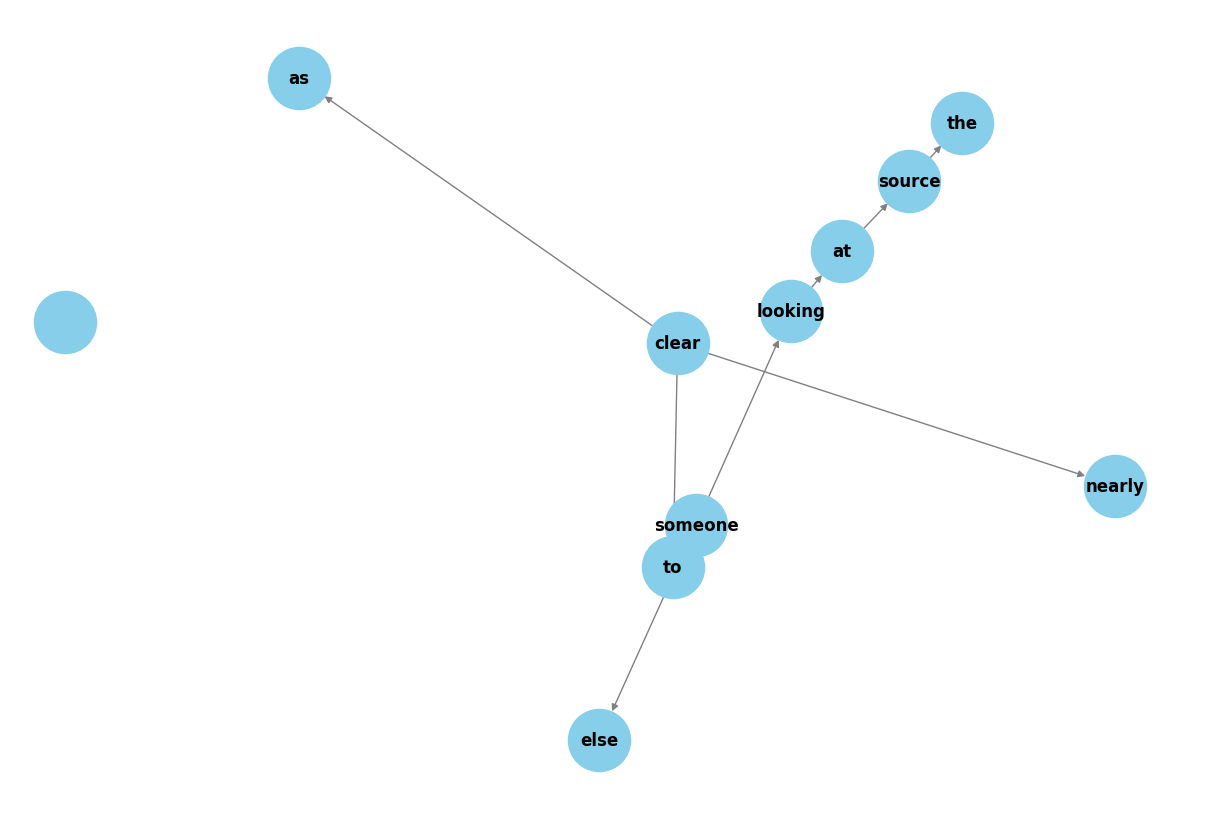

 else           @  nearly as clear to someone else looking at the source 43.125


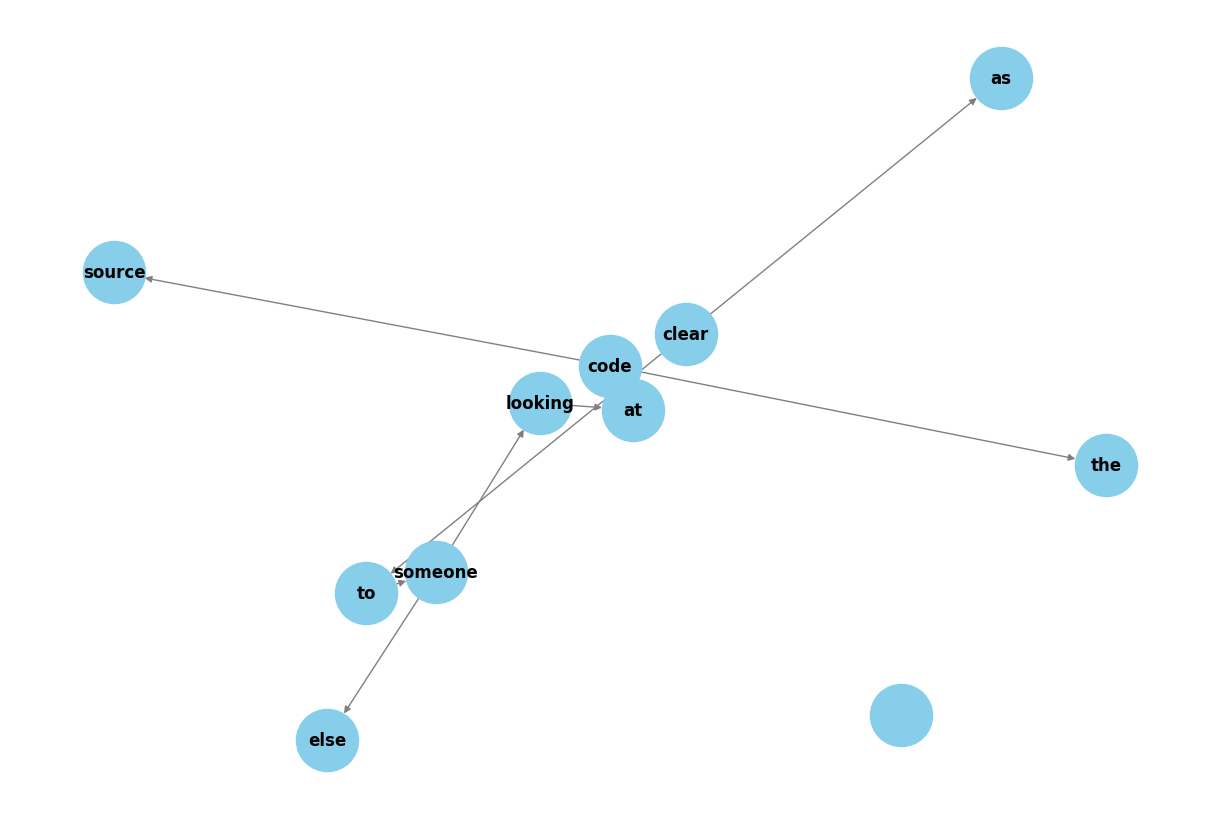

 looking        @  as clear to someone else looking at the source code 42.625


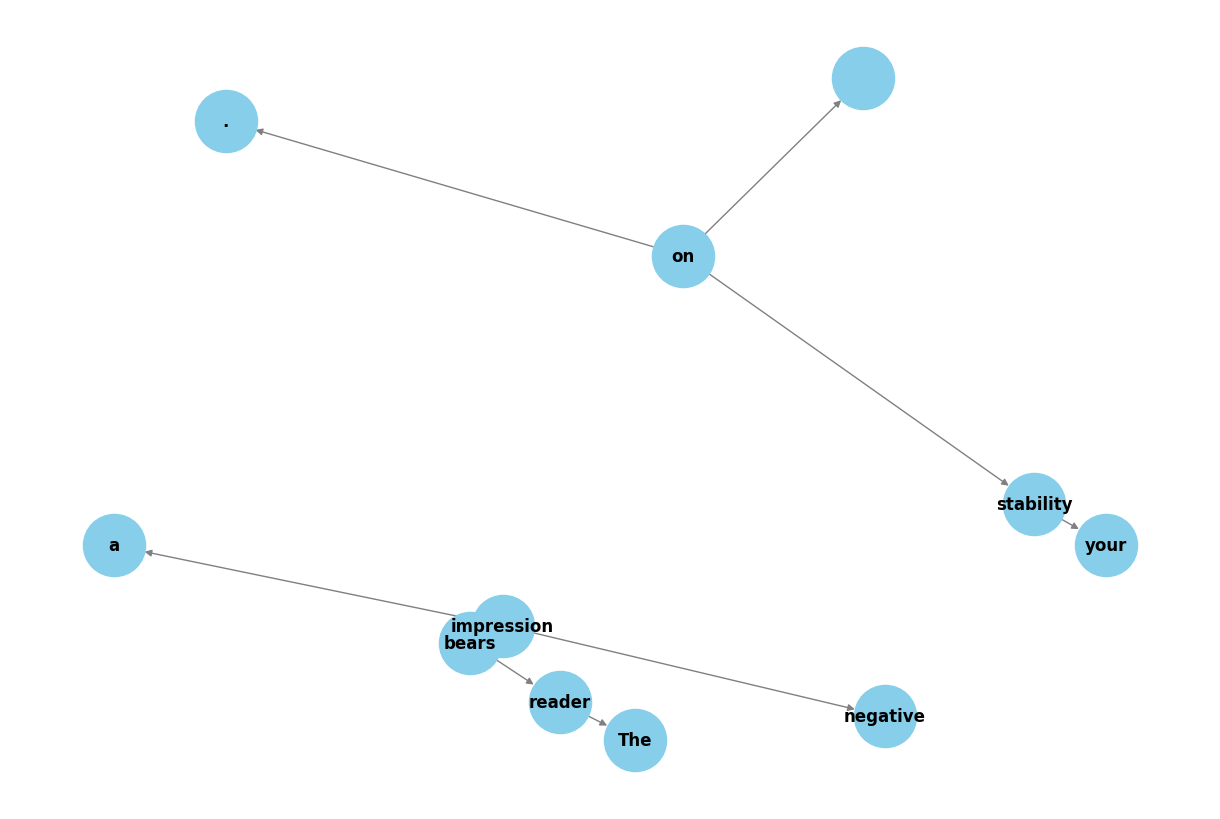

 reader         @  on your stability. The reader bears a negative impression 41.875


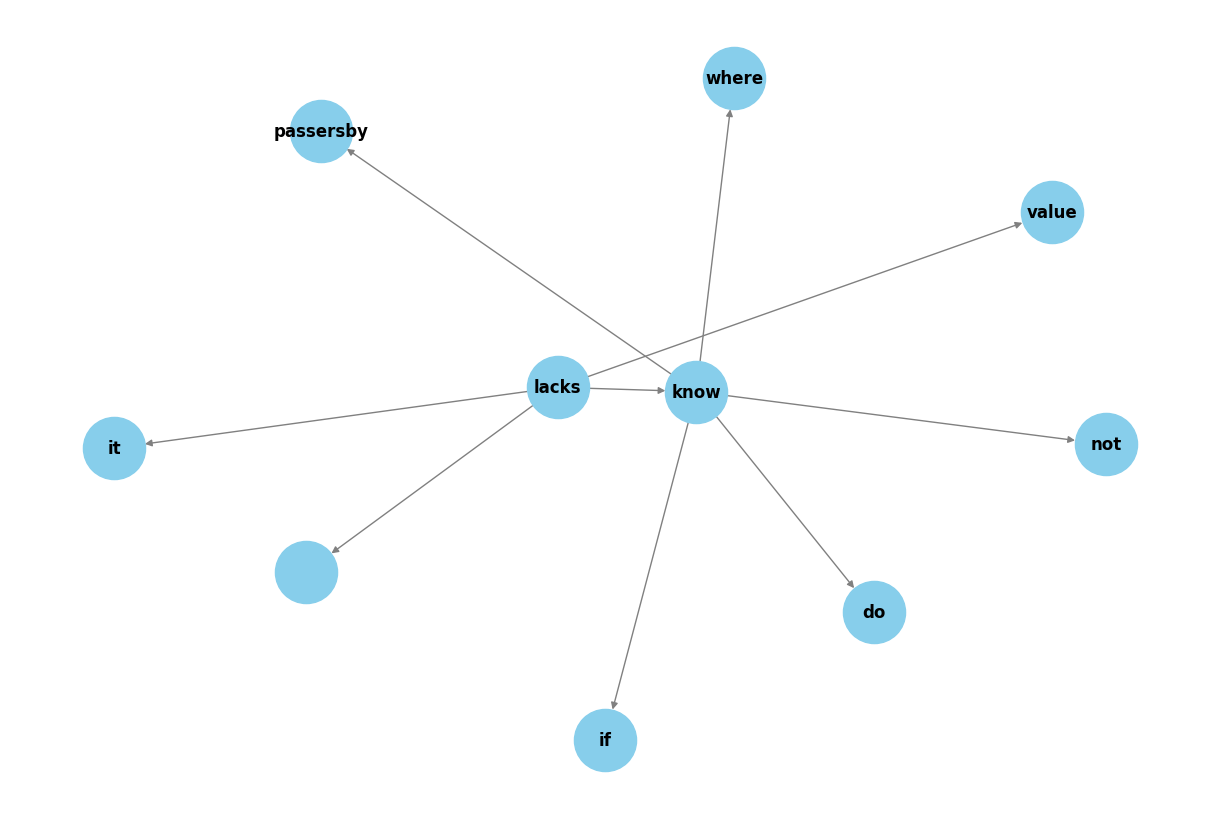

by              @  it lacks value if passersby do not know where     39.78125


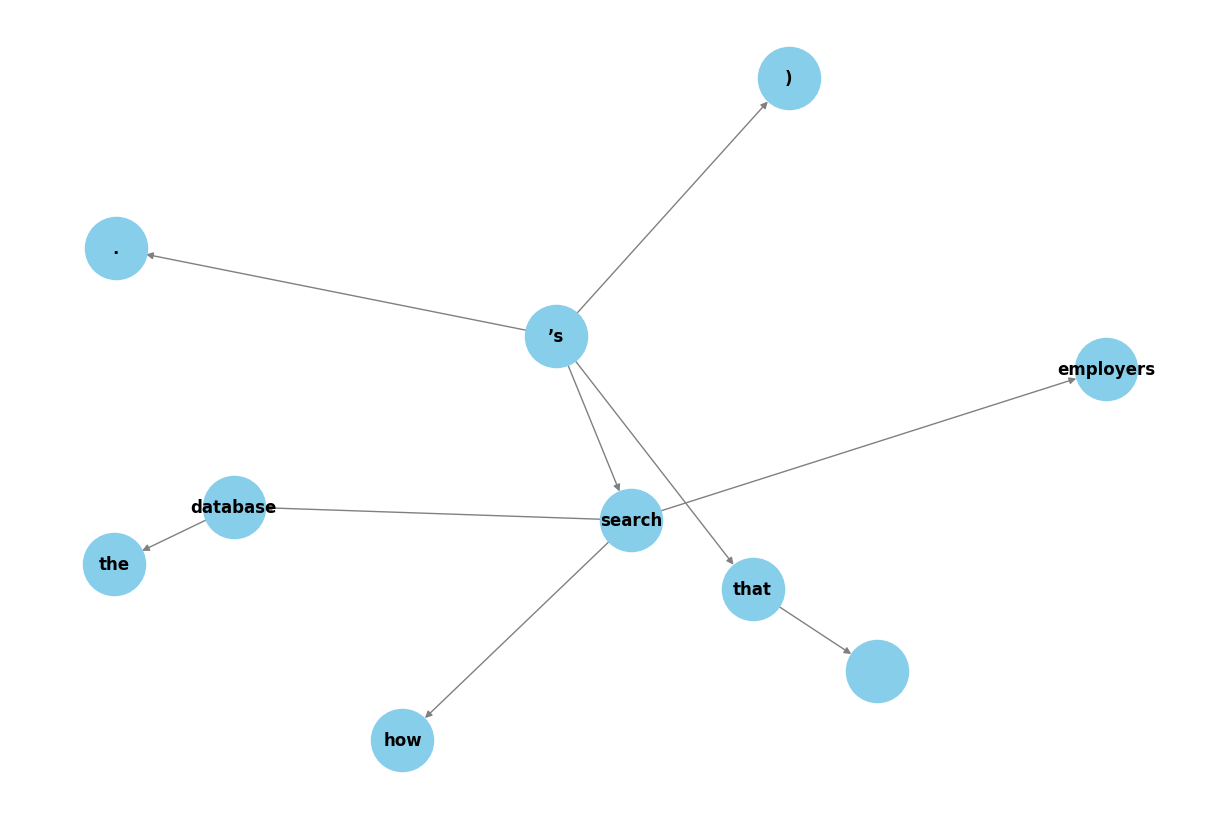

 search         @  that’s how employers search the database).        37.90625


In [13]:
visualize_feature(3000, activations, locations)